In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
dataset_folder = "../../dataset/"

# Microsoft

In [3]:
microsoft_df = pd.read_csv(dataset_folder + "microsoft.csv")

In [4]:
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(microsoft_df.values.reshape(-1,1))
scaled

array([[0.00210064],
       [0.        ],
       [0.00615535],
       ...,
       [0.95236932],
       [0.9358085 ],
       [0.95495848]])

In [7]:
def split_data(stock, lookback):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1185, 30, 1)
y_train.shape:  (1185, 1)
X_test.shape:  (296, 30, 1)
y_test.shape:  (296, 1)


In [8]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers, drop_prob=0.2):
        super(RNN, self).__init__()
        
        #Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining layers
        #RNN
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        #activation function
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self,batch_size):
        #generates the first hidden state of zeros used in the forward pass
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="RNN"):
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = RNN(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):

        h = model.init_hidden(batch_size)
        avg_loss = 0.
        for x, label in train_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            
            loss = criterion(out, label.float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        #print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        #epoch_times.append(current_time-start_time)
    #print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        h = model.init_hidden(1)
        criterion = nn.MSELoss()
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss = loss.item()
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))

    return predictions, values, loss

In [10]:
lr = 0.001
rnn_micro = train(train_loader, lr, model_type="RNN")

Starting Training of RNN model


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5 Done, Total Loss: 0.024888522353851132
Epoch 2/5 Done, Total Loss: 0.002843252404191945
Epoch 3/5 Done, Total Loss: 0.0003333863739195901
Epoch 4/5 Done, Total Loss: 0.00014614308464741852
Epoch 5/5 Done, Total Loss: 0.00012295681113351343


In [11]:
predictions, values, loss = evaluate(rnn_micro,test_loader)
print("testing set loss: {}".format(loss))

testing set loss: 0.006768396589905024


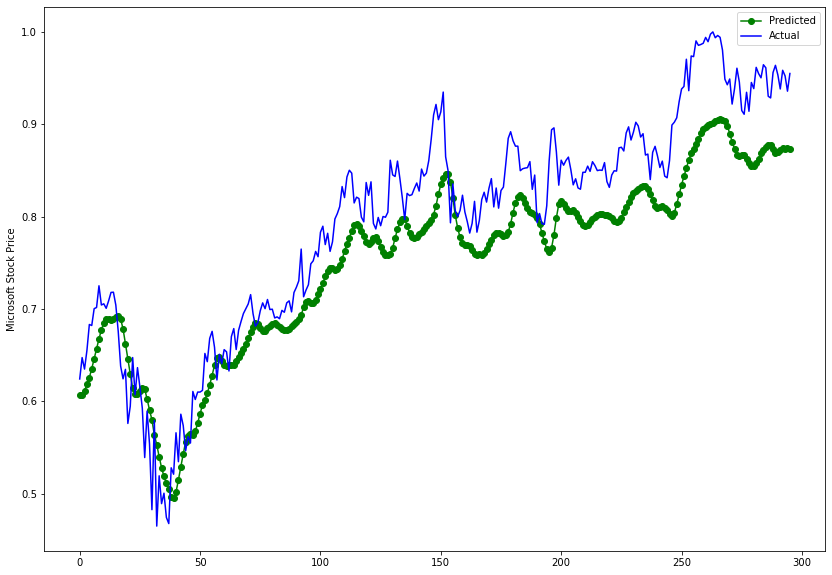

In [12]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

## Artificial Data

In [13]:
art_data = pd.read_csv(dataset_folder +"Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [14]:
lookback = 30 # choose sequence length
train_x,train_y,test_x,test_y = split_data(art_data, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5822, 30, 1)
y_train.shape:  (5822, 1)
X_test.shape:  (1455, 30, 1)
y_test.shape:  (1455, 1)


In [15]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [16]:
lr = 0.001
rnn_art1 = train(train_loader, lr, model_type="RNN")

Starting Training of RNN model


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5 Done, Total Loss: 0.0013407189177491495
Epoch 2/5 Done, Total Loss: 3.391987643731732e-05
Epoch 3/5 Done, Total Loss: 2.69128708977304e-05
Epoch 4/5 Done, Total Loss: 2.8578535178288197e-05
Epoch 5/5 Done, Total Loss: 2.438510077303767e-05


In [17]:
predictions, values, loss = evaluate(rnn_art1,test_loader)
print("testing set loss: {}".format(loss))

testing set loss: 7.505981193389744e-05


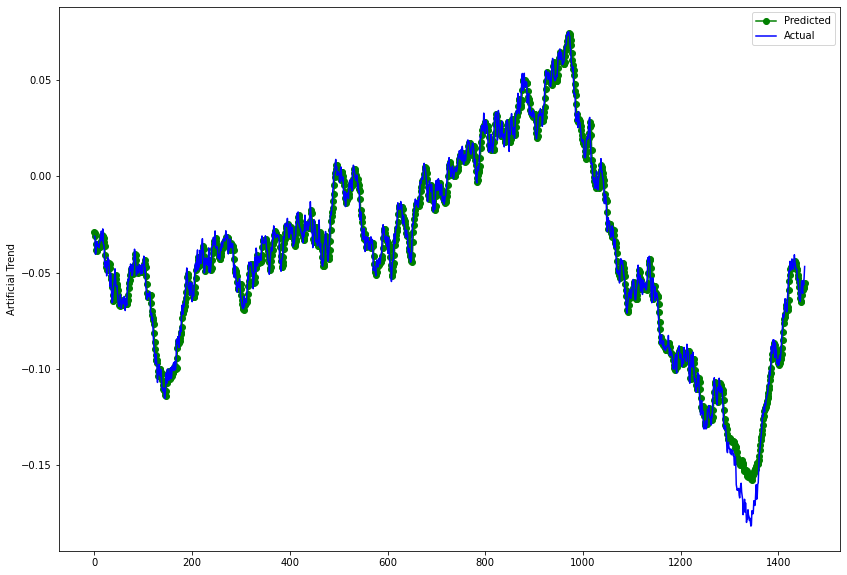

In [18]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

## Crude Oil

In [19]:
oil_data = pd.read_csv(dataset_folder +"oil.csv")
oil_data['DATE'] = pd.to_datetime(oil_data['DATE'])
oil_data.set_index('DATE',inplace=True)
len(oil_data)

1566

In [20]:
oil_data[oil_data['DCOILBRENTEU'] == "."] = np.NaN
oil_data.dropna(inplace=True)
oil_data['DCOILBRENTEU'] = oil_data['DCOILBRENTEU'].astype("float")
oil_data

,DCOILBRENTEU
DATE,
2015-11-02,47.91
2015-11-03,48.00
2015-11-04,46.96
2015-11-05,47.19
2015-11-06,46.09
...,...
2021-10-26,85.11
2021-10-27,84.12
2021-10-28,83.40


In [21]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_oil = scaler.fit_transform(oil_data.values)

train_x,train_y,test_x,test_y = split_data(scaled_oil, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1199, 30, 1)
y_train.shape:  (1199, 1)
X_test.shape:  (300, 30, 1)
y_test.shape:  (300, 1)


In [22]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [23]:
lr = 0.001
rnn_oil = train(train_loader, lr, hidden_dim = 256, model_type="RNN")

Starting Training of RNN model


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5 Done, Total Loss: 0.08605423512765104
Epoch 2/5 Done, Total Loss: 0.017328173387795687
Epoch 3/5 Done, Total Loss: 0.003632851485033623
Epoch 4/5 Done, Total Loss: 0.0009623573019376232
Epoch 5/5 Done, Total Loss: 0.0009792960287692647


In [24]:
predictions, values, loss = evaluate(rnn_oil,test_loader)
print("testing set loss: {}".format(loss))

testing set loss: 2.689280563572538e-06


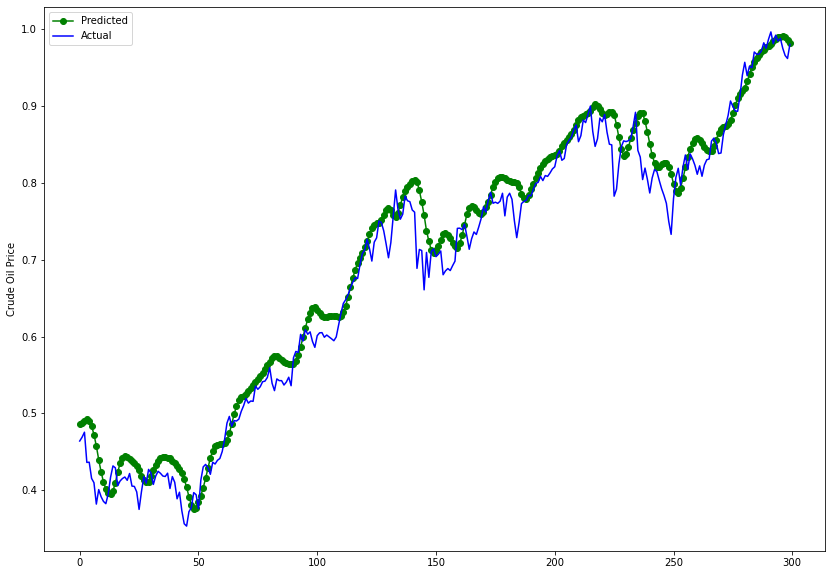

In [25]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

## Bitcoin

In [26]:
coin_df = pd.read_csv(dataset_folder + "coin.csv")
coin_df['Date'] = pd.to_datetime(coin_df['Date'])
coin_df.set_index('Date', inplace=True)
coin_df = pd.DataFrame(coin_df['Close'])
coin_df.dropna(inplace=True)
coin_df

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000
...,...
2021-07-02 23:59:59,33897.048590
2021-07-03 23:59:59,34668.548402
2021-07-04 23:59:59,35287.779766


In [27]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_coin = scaler.fit_transform(coin_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_coin, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (2369, 30, 1)
y_train.shape:  (2369, 1)
X_test.shape:  (592, 30, 1)
y_test.shape:  (592, 1)


In [28]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [29]:
lr = 0.001
rnn_coin = train(train_loader, lr, hidden_dim = 256, model_type="RNN")

Starting Training of RNN model


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5 Done, Total Loss: 0.0028962663538451934
Epoch 2/5 Done, Total Loss: 0.0006460446643728033
Epoch 3/5 Done, Total Loss: 4.384805024037141e-05
Epoch 4/5 Done, Total Loss: 3.276046036999843e-05
Epoch 5/5 Done, Total Loss: 3.3818513865962565e-05


In [30]:
predictions, values, loss = evaluate(rnn_coin,test_loader)
print("testing set loss: {}".format(loss))

testing set loss: 0.008379032835364342


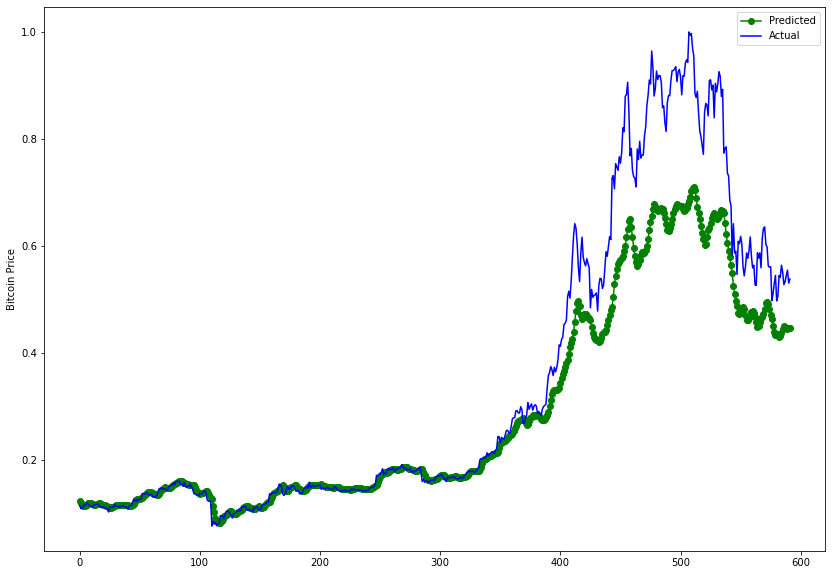

In [31]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

## S&P500

In [32]:
sp_df = pd.read_csv(dataset_folder + "sp500.csv")
sp_df['Date'] = pd.to_datetime(sp_df['Date'])
sp_df.set_index('Date', inplace=True)
sp_df = pd.DataFrame(sp_df['SP500'])
sp_df.dropna(inplace=True)
sp_df

,SP500
Date,
1871-01-01,4.44
1871-02-01,4.50
1871-03-01,4.61
1871-04-01,4.74
1871-05-01,4.86
...,...
2017-12-01,2664.34
2018-01-01,2789.80
2018-02-01,2705.16


In [33]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_sp = scaler.fit_transform(sp_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_sp, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1390, 30, 1)
y_train.shape:  (1390, 1)
X_test.shape:  (348, 30, 1)
y_test.shape:  (348, 1)


In [34]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [35]:
lr = 0.001
rnn_sp = train(train_loader, lr, hidden_dim = 256, model_type="RNN")

Starting Training of RNN model


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5 Done, Total Loss: 0.0007168477459345013
Epoch 2/5 Done, Total Loss: 0.0003456196320171113
Epoch 3/5 Done, Total Loss: 0.00021721807501134683
Epoch 4/5 Done, Total Loss: 5.015786055515664e-05
Epoch 5/5 Done, Total Loss: 1.2862738815653887e-05


In [36]:
predictions, values, loss = evaluate(rnn_sp,test_loader)
print("testing set loss: {}".format(loss))

testing set loss: 0.20006002485752106


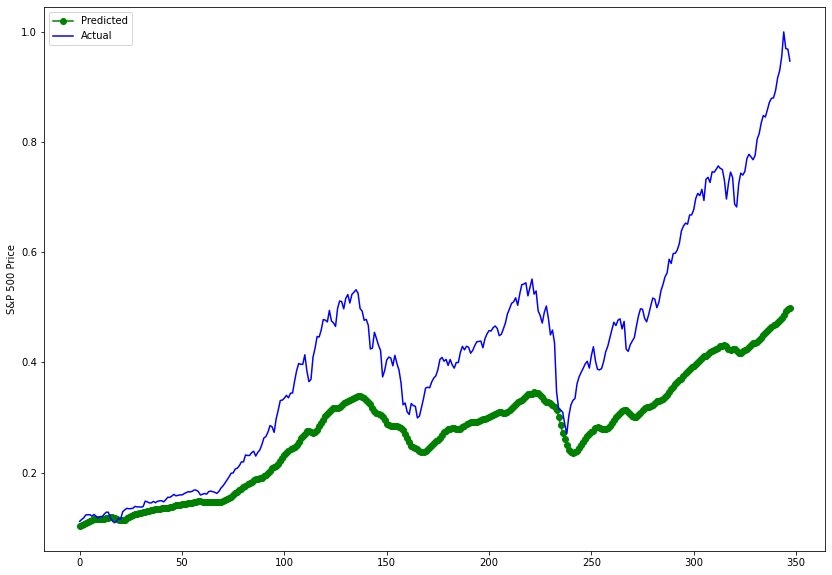

In [37]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

## 